# Forward simulations 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

In [2]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14

In [3]:
line = "46800E"

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

# TODO: see if we can serialize the survey and save from the previous notebook

In [22]:
def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [23]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=False)

In [24]:
# initialize an empty list for each 
source_list = []

# center the survey and work in local coordinates
x_local = 0.5*(np.min(dc_data_dict["a_locations"]) + np.max(np.hstack(dc_data_dict["n_locations"])))

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i] - x_local, 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i] - x_local,
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i] - x_local, 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i] - x_local, 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [25]:
survey = dc.Survey(source_list=source_list)

In [26]:
min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))
n_cells_per_spacing = 4

dx = min_electrode_spacing / n_cells_per_spacing
dz = min_electrode_spacing / n_cells_per_spacing

print(
    f"We will use a base mesh with {dx} m x {dz} m cells"
)

We will use a base mesh with 25.0 m x 25.0 m cells


In [27]:
core_domain_x = np.r_[
    survey.electrode_locations[:, 0].min(),
    survey.electrode_locations[:, 0].max()
]

core_domain_x

array([-1600.,  1600.])

In [28]:
# find the maximum spacing between source, receiver midpoints
mid_ab = (survey.locations_a + survey.locations_b)/2
mid_mn = (survey.locations_m + survey.locations_n)/2
seperation_ab_mn = np.abs(mid_ab - mid_mn)
max_seperation = seperation_ab_mn.max()
print(f"The maximum seperation is {max_seperation}m")

core_domain_z = np.r_[-max_seperation/3., 0.]
core_domain_z

The maximum seperation is 800.0m


array([-266.66666667,    0.        ])

In [29]:
n_core_extra = 4 
n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra*2  # on each side
n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra  # just below

padding_factor = 1.3
n_pad_x = 8
n_pad_z = 8

In [30]:
hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

mesh = discretize.TensorMesh([hx, hz])

# origin of the mesh
mesh.x0 = np.r_[
    -mesh.hx[:n_pad_x + n_core_extra].sum() + core_domain_x.min(),
    -mesh.hy.sum()
]

mesh

TensorMesh: 3,496 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    152     -2,475.37      2,475.37     25.00    203.93    1.30
   y     23     -1,150.37         -0.00     25.00    203.93    1.30

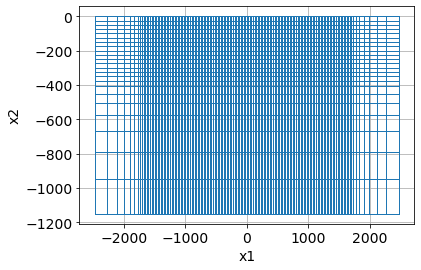

In [31]:
fig, ax = plt.subplots()
mesh.plotGrid(ax=ax)

# design a model

In [73]:
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

xlim_resistive_block = np.r_[-1000, -500]
ylim_resistive_block = np.r_[-200, -50]

xlim_conductive_block = np.r_[500, 1000]
ylim_conductive_block = np.r_[-200, -50]

### put the model on the mesh

In [74]:
rho = rho_background * np.ones(mesh.nC)

# resistive block
inds_resistive_block = (
    (mesh.gridCC[:, 0] >= xlim_resistive_block.min()) & (mesh.gridCC[:, 0] <= xlim_resistive_block.max()) &
    (mesh.gridCC[:, 1] >= ylim_resistive_block.min()) & (mesh.gridCC[:, 1] <= ylim_resistive_block.max())
)

rho[inds_resistive_block] = rho_resistive_block

# conductive block
inds_conductive_block = (
    (mesh.gridCC[:, 0] >= xlim_conductive_block.min()) & (mesh.gridCC[:, 0] <= xlim_conductive_block.max()) &
    (mesh.gridCC[:, 1] >= ylim_conductive_block.min()) & (mesh.gridCC[:, 1] <= ylim_conductive_block.max())
)

rho[inds_conductive_block] = rho_conductive_block

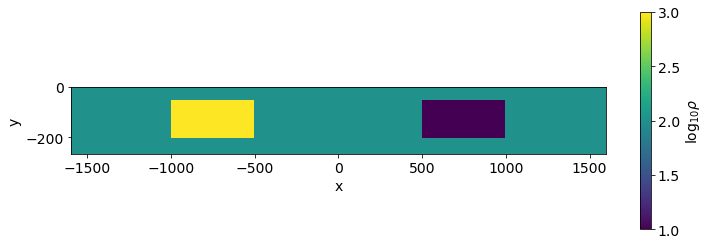

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
out = mesh.plotImage(np.log10(rho), ax=ax)
plt.colorbar(out[0], ax=ax, label="log$_{10} \\rho$")
ax.set_xlim(core_domain_x)
ax.set_ylim(core_domain_z)
ax.set_aspect(1.5)

In [76]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey, storeJ=True
)

In [77]:
%%time 

# run the forward simulation over the half-space & plot apparent resistivities
model = np.ones(mesh.nC) * np.log(rho)
synthetic_data = simulation_dc.make_synthetic_data(model)

CPU times: user 799 ms, sys: 53.7 ms, total: 853 ms
Wall time: 230 ms


Text(0.5, 0, 'Northing (m)')

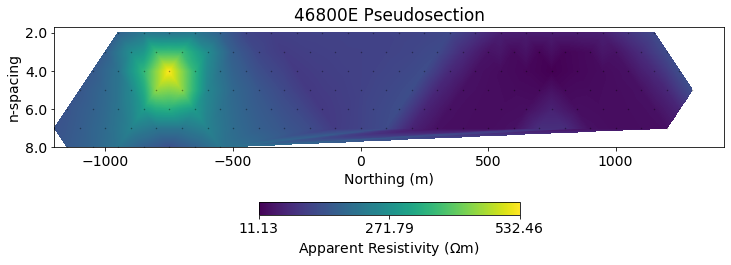

In [78]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

dc.utils.plot_pseudosection(
    synthetic_data, data_type="apparent resistivity", # clim=clim,
    plot_type="pcolor", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} Pseudosection")
ax.set_xlabel("Northing (m)")


In [ ]:
# develop an app for the fields object

In [79]:
# save the data object with synthetic data

In [ ]:
# move on to the next notebook 